In [26]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import time
import tensorflow as tf

In [27]:
# datos: secuencia de observaciones como una lista o matriz 2D NumPy. Necesario.
# n_in: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len (datos)] Opcional. El valor predeterminado es 1.
# n_out: Número de observaciones como salida (y). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
# dropnan: booleano si se deben soltar o no filas con valores NaN. Opcional. Por defecto es verdadero.


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# observaciones pasadas  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# tiempos futuros  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
data = pd.read_excel('../PreparacionDatos/floraTotal_quarter.xlsx' , sheet_name='floraTotal_quarter' ,header=0)

In [5]:
data.columns

Index(['Unnamed: 0', 'CO', 'DirVien', 'H2S (ug/m3)', 'Humedad', 'Lluvia',
       'Motos_vehiculos_particulares', 'NO2', 'O3', 'PM10', 'Poblacion',
       'RSolar', 'SO2', 'Temp', 'VelVien'],
      dtype='object')

In [6]:
#Borro solo dejo PM10, lluvia, población y parque automovilístico

data = data.drop(['Unnamed: 0', 'CO', 'DirVien', 'H2S (ug/m3)', 'Humedad', 'NO2', 'O3', 'RSolar', 'SO2', 'Temp', 'VelVien'], axis=1)


In [7]:
data.columns

Index(['Lluvia', 'Motos_vehiculos_particulares', 'PM10', 'Poblacion'], dtype='object')

In [8]:
#Modelo de 4 carateristicas.

new_order = [2,1,0,3]
data = data[data.columns[new_order]]

data.describe()

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion
count,32.000000,32.000000,32.000000,3.200000e+01
mean,29.407487,498530.625000,0.282681,2.332282e+06
std,8.065527,96047.452489,0.186494,5.833838e+04
min,16.134058,348066.000000,0.015700,2.244668e+06
25%,24.819687,426908.500000,0.173525,2.288403e+06
50%,28.018413,505229.000000,0.244030,2.332209e+06
75%,33.663911,575963.250000,0.389344,2.376097e+06
max,47.904537,630478.000000,0.939613,2.420114e+06


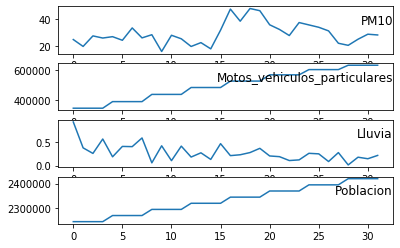

<Figure size 1728x432 with 0 Axes>

In [9]:
# Reprecentacion de los datos.
from matplotlib import pyplot
groups = [0,1,2,3]
i = 1
values = data.values
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.figure(figsize=(24,6))
pyplot.show()

In [10]:
data.describe()

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion
count,32.000000,32.000000,32.000000,3.200000e+01
mean,29.407487,498530.625000,0.282681,2.332282e+06
std,8.065527,96047.452489,0.186494,5.833838e+04
min,16.134058,348066.000000,0.015700,2.244668e+06
25%,24.819687,426908.500000,0.173525,2.288403e+06
50%,28.018413,505229.000000,0.244030,2.332209e+06
75%,33.663911,575963.250000,0.389344,2.376097e+06
max,47.904537,630478.000000,0.939613,2.420114e+06


In [ ]:
data.to_excel("FloraTotal_3mes.xlsx", sheet_name='FloraTotal',encoding='UTF-8') #

In [11]:
values = data.values

#Normalize features(0,1)
#Este estimador escala y traduce cada característica
#individualmente de modo que esté en el rango dado en el conjunto de entrenamiento
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.277607   0.000000   1.000000   0.000000  0.117549  0.000000  0.397346   
2   0.117549   0.000000   0.397346   0.000000  0.362690  0.000000  0.267852   
3   0.362690   0.000000   0.267852   0.000000  0.312961  0.000000  0.603016   
4   0.312961   0.000000   0.603016   0.000000  0.344566  0.153184  0.189067   
5   0.344566   0.153184   0.189067   0.142408  0.260727  0.153184  0.430659   

    var4(t)  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.142408  
5  0.142408  


In [13]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)',
       'var2(t)', 'var3(t)', 'var4(t)'],
      dtype='object')

In [14]:
#Dejo la variable objetico en PM10 (T) y y todas (T-1)...................
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.277607   0.000000   1.000000   0.000000  0.117549
2   0.117549   0.000000   0.397346   0.000000  0.362690
3   0.362690   0.000000   0.267852   0.000000  0.312961
4   0.312961   0.000000   0.603016   0.000000  0.344566
5   0.344566   0.153184   0.189067   0.142408  0.260727


In [62]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)'], dtype='object')

In [15]:
values = reframed.values

#Datos de entrenamiento y pruebas:
n_train_hours = 23
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [16]:
# Datos de entrada y de salida.
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]


#Remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23, 1, 4) (23, 1) (8, 1, 4) (8, 1)


In [18]:
#Diseñando la red neuronal.
model = Sequential()

#Capa de entrada (unidades, 1, 4)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Capa de salida.
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.name="LTSM_cali_3meses"

#fit(x=None, y=None, batch_size=None, epochs=1, 
#verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
#shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 23 samples, validate on 8 samples
Epoch 1/50





 - 1s - loss: 0.4135 - val_loss: 0.3370
Epoch 2/50
 - 0s - loss: 0.4068 - val_loss: 0.3269
Epoch 3/50
 - 0s - loss: 0.4002 - val_loss: 0.3167
Epoch 4/50
 - 0s - loss: 0.3935 - val_loss: 0.3066
Epoch 5/50
 - 0s - loss: 0.3869 - val_loss: 0.2964
Epoch 6/50
 - 0s - loss: 0.3802 - val_loss: 0.2863
Epoch 7/50
 - 0s - loss: 0.3738 - val_loss: 0.2762
Epoch 8/50
 - 0s - loss: 0.3678 - val_loss: 0.2661
Epoch 9/50
 - 0s - loss: 0.3617 - val_loss: 0.2560
Epoch 10/50
 - 0s - loss: 0.3557 - val_loss: 0.2460
Epoch 11/50
 - 0s - loss: 0.3496 - val_loss: 0.2359
Epoch 12/50
 - 0s - loss: 0.3435 - val_loss: 0.2274
Epoch 13/50
 - 0s - loss: 0.3375 - val_loss: 0.2196
Epoch 14/50
 - 0s - loss: 0.3313 - val_loss: 0.2119
Epoch 15/50
 - 0s - loss: 0.3252 - val_loss: 0.2041
Epoch 16/50
 - 0s - loss: 0.3197 - val_loss: 0.1968
Epoch 17/50
 - 0s - loss: 0.3147

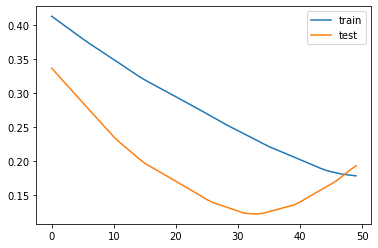

In [19]:

# Ajustado el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Seguimiento al modelo 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
yhat = model.predict(test_X)
test_X.shape

(8, 1, 4)

In [21]:
# Realizo la prediccion.

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

(8, 4)

In [22]:
# invierco el scalar de la prediccion
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#Invierco el scalar de los dato realizes
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.179


In [24]:
# Vuelvo el modelo un archivo .json
model_json = model.to_json()
with open("../Modelamiento/model.json", "w") as json_file:
    json_file.write(model_json)
    

# Guardar el Modelo
model.save_weights('../Modelamiento/LTSM_Cali_3meses.h5')

In [144]:
model

In [40]:
train.shape

(4000, 14)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
